### Temi Note

## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.

Create 1 slide with informative visualization for each question. Explore data using SQL and Python but use Tableau for final visualization.

Don't limit your EDA to these 10 questions. Let's be creative :).

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from datetime import datetime

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [6]:
f = pd.read_csv('exporate\delay_month.csv')

In [10]:
delay = f.sort_values(['Year','Month'],ignore_index= True)

In [30]:
month = delay.groupby('Month',as_index= False).agg({'avg':'mean'})
month.head()

,Month,avg
0,1,9.827812
1,2,11.737970
2,3,8.403554
3,4,9.356035
4,5,11.355161


#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [54]:
WOearly[WOearly.Year== 2018].sort_values('avg_delay',ascending=False)

,date_trunc,Date,Year,Month,avg_delay,sum_delay,Nos_flight
7,2018-08-01 00:00:00+00,2018-08-01,2018,8,45.270275,11696662,258374
9,2018-07-01 00:00:00+00,2018-07-01,2018,7,43.121224,11317812,262465
0,2018-06-01 00:00:00+00,2018-06-01,2018,6,42.333918,10836975,255988
13,2018-01-01 00:00:00+00,2018-01-01,2018,1,40.249546,7950533,197531
8,2018-05-01 00:00:00+00,2018-05-01,2018,5,40.209572,9258656,230260
10,2018-09-01 00:00:00+00,2018-09-01,2018,9,39.352757,7099316,180402
15,2018-02-01 00:00:00+00,2018-02-01,2018,2,38.878303,7326655,188451
5,2018-11-01 00:00:00+00,2018-11-01,2018,11,37.665112,8173141,216995
17,2018-04-01 00:00:00+00,2018-04-01,2018,4,36.765109,7574458,206023
2,2018-12-01 00:00:00+00,2018-12-01,2018,12,36.607714,8011891,218858


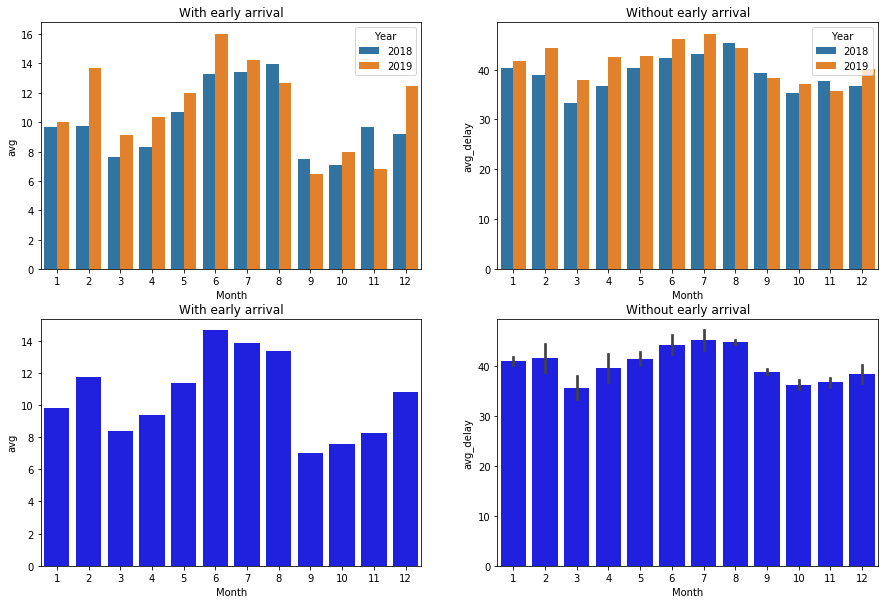

In [43]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10))
sns.barplot(x='Month',y='avg',hue='Year',data=delay,ax=ax1,).set_title('With early arrival')
sns.barplot(x='Month',y='avg',data=month,ax=ax3,color="blue").set_title('With early arrival')
sns.barplot(x='Month',y='avg_delay',hue='Year',data=WOearly,ax=ax2).set_title('Without early arrival')
sns.barplot(x='Month',y='avg_delay',data=WOearly,ax=ax4,color="blue").set_title('Without early arrival')
plt.show;

In [37]:
WOearly = pd.read_csv('exporate\delay_withoutearly.csv')

In [38]:
WOearly.head()

,date_trunc,Date,Year,Month,avg_delay,sum_delay,Nos_flight
0,2018-06-01 00:00:00+00,2018-06-01,2018,6,42.333918,10836975,255988
1,2019-11-01 00:00:00+00,2019-11-01,2019,11,35.773384,6769469,189232
2,2018-12-01 00:00:00+00,2018-12-01,2018,12,36.607714,8011891,218858
3,2019-03-01 00:00:00+00,2019-03-01,2019,3,37.913607,8455341,223016
4,2019-06-01 00:00:00+00,2019-06-01,2019,6,46.132093,12776237,276949


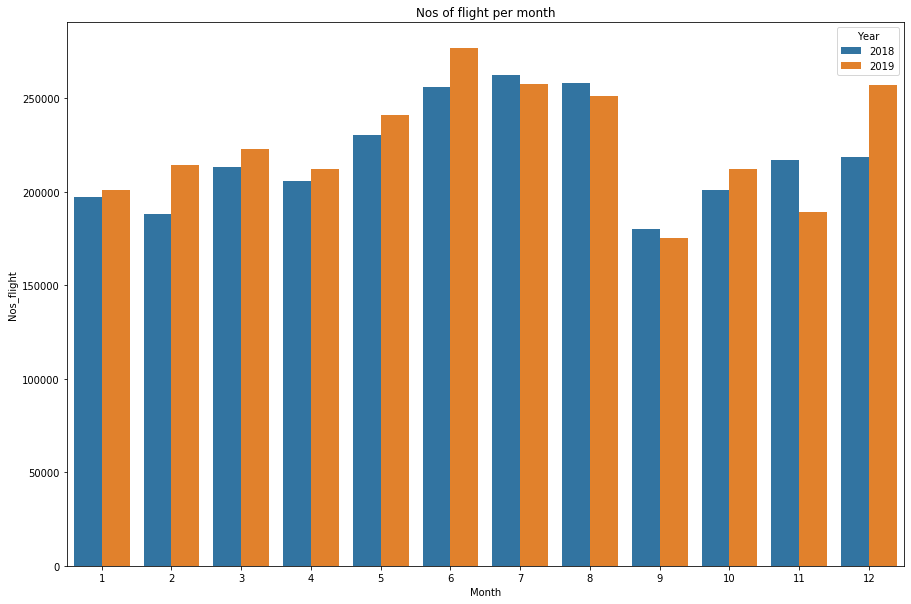

In [46]:
fig, (ax1) = plt.subplots(1,1,figsize=(15,10))
sns.barplot(x='Month',y='Nos_flight',hue='Year',data=WOearly,ax=ax1).set_title('Nos of flight per month')
plt.show;

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [55]:
f = pd.read_csv('exporate\weather.csv')

In [101]:
f=f.drop(columns='to_date')
f.head()

,fl_date,avg,sum,count,origin_city_name,dest_city_name,date_trunc
0,2019-11-06,1.0,1,1,"Austin, TX","Newark, NJ",2019-11-01
1,2019-10-12,1.0,1,1,"Chicago, IL","West Palm Beach/Palm Beach, FL",2019-10-01
2,2019-11-24,1.0,1,1,"Albany, NY","Tampa, FL",2019-11-01
3,2019-10-09,1.0,1,1,"Charlotte Amalie, VI","Atlanta, GA",2019-10-01
4,2019-10-12,1.0,1,1,"Charlotte Amalie, VI","Newark, NJ",2019-10-01


In [97]:
f.date_trunc=f.date_trunc.str.slice(0,10)
f.date_trunc=pd.to_datetime(f['date_trunc'])

In [102]:
f.head()

,fl_date,avg,sum,count,origin_city_name,dest_city_name,date_trunc
0,2019-11-06,1.0,1,1,"Austin, TX","Newark, NJ",2019-11-01
1,2019-10-12,1.0,1,1,"Chicago, IL","West Palm Beach/Palm Beach, FL",2019-10-01
2,2019-11-24,1.0,1,1,"Albany, NY","Tampa, FL",2019-11-01
3,2019-10-09,1.0,1,1,"Charlotte Amalie, VI","Atlanta, GA",2019-10-01
4,2019-10-12,1.0,1,1,"Charlotte Amalie, VI","Newark, NJ",2019-10-01


In [106]:
f[f.date_trunc == '2019-11-01'].head()

,fl_date,avg,sum,count,origin_city_name,dest_city_name,date_trunc
0,2019-11-06,1.0,1,1,"Austin, TX","Newark, NJ",2019-11-01
2,2019-11-24,1.0,1,1,"Albany, NY","Tampa, FL",2019-11-01
6,2019-11-05,1.0,1,1,"Austin, TX","New Orleans, LA",2019-11-01
9,2019-11-04,1.0,1,1,"Austin, TX","Salt Lake City, UT",2019-11-01
13,2019-11-04,1.0,1,1,"Brownsville, TX","Houston, TX",2019-11-01


#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

0        2019-11-01
1        2019-10-01
2        2019-11-01
3        2019-10-01
4        2019-10-01
            ...    
112060   2019-08-01
112061   2019-08-01
112062   2019-06-01
112063   2019-06-01
112064   2019-07-01
Name: date_trunc, Length: 112065, dtype: datetime64[ns]

In [81]:
# f.date_trunc.apply(lambda x:datetime.strptime(x, "%Y-%M-%d"))

0        2019-01-01 00:11:00
1        2019-01-01 00:10:00
2        2019-01-01 00:11:00
3        2019-01-01 00:10:00
4        2019-01-01 00:10:00
                 ...        
112060   2019-01-01 00:08:00
112061   2019-01-01 00:08:00
112062   2019-01-01 00:06:00
112063   2019-01-01 00:06:00
112064   2019-01-01 00:07:00
Name: date_trunc, Length: 112065, dtype: datetime64[ns]

In [ ]:
a.s

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?